## Прогнозирование температуры звезды
Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

## Загрузка данных

In [1]:
!pip install skorch

     |████████████████████████████████| 155 kB 1.6 MB/s            


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch  
from sklearn.metrics import mean_squared_error
from skorch import NeuralNetRegressor 

In [3]:
df = pd.read_csv(url, index_col=0)

In [4]:
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [5]:
df.describe()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000


## Предобработка и анализ данных

Text(0.5, 0, 'Star type')

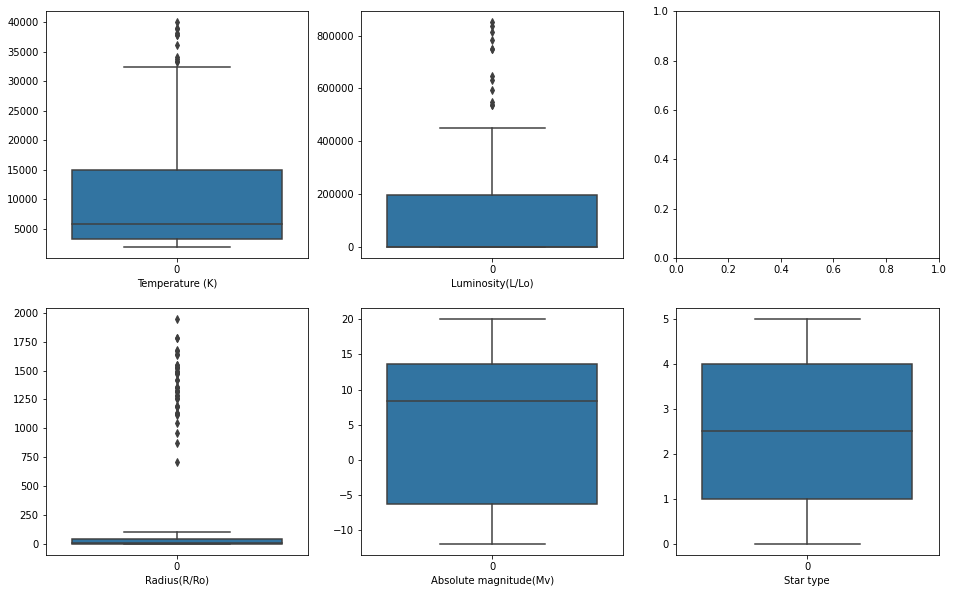

In [6]:
f, (ax1, ax2) = plt.subplots(2, 3, figsize=(16,10))
sns.boxplot(data=df['Temperature (K)'], ax=ax1[0])
sns.boxplot(data=df['Luminosity(L/Lo)'], ax=ax1[1])
sns.boxplot(data=df['Radius(R/Ro)'], ax=ax2[0])
sns.boxplot(data=df['Absolute magnitude(Mv)'], ax=ax2[1])
sns.boxplot(data=df['Star type'], ax=ax2[2])
ax1[0].set_xlabel("Temperature (K)")
ax1[1].set_xlabel("Luminosity(L/Lo)")
ax2[0].set_xlabel("Radius(R/Ro)")
ax2[1].set_xlabel("Absolute magnitude(Mv)")
ax2[2].set_xlabel("Star type")

В `Temperature (K)`, `Luminosity(L/Lo)` и `Radius(R/Ro)` есть выбросы.

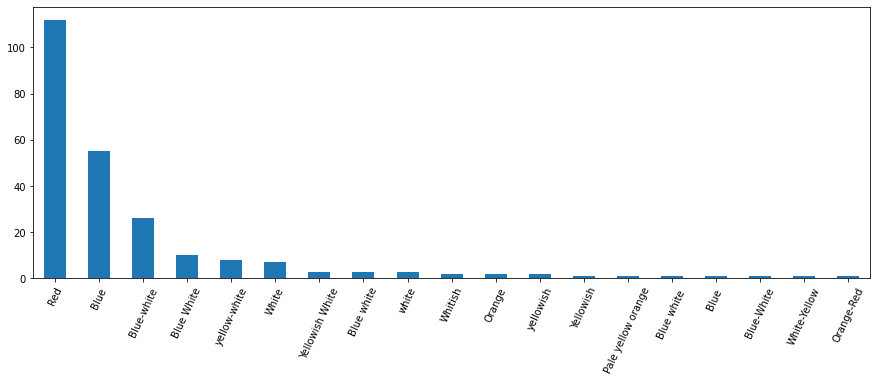

In [7]:
df['Star color'].value_counts().plot(kind='bar', figsize=(15,5), rot=65);

Есть одинаковые цвета но в разном регистре и с тире.

In [8]:
df['Star color'] = df['Star color'].apply(lambda x: ' '.join(sorted(x.lower().replace('-', ' ').split())))

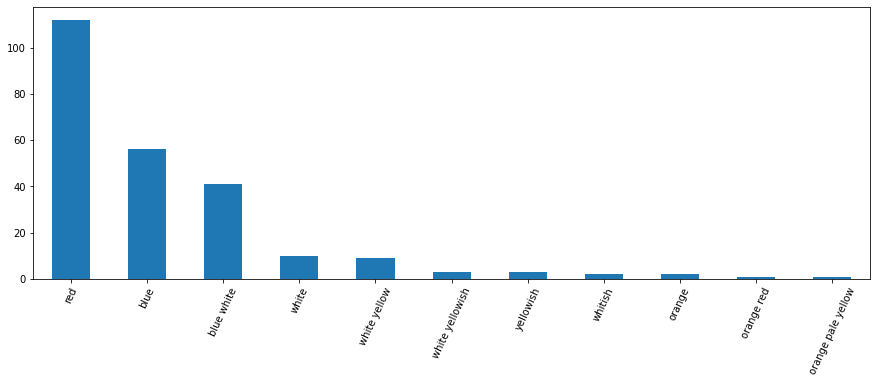

In [9]:
df['Star color'].value_counts().plot(kind='bar', figsize=(15,5), rot=65);

In [11]:
df = df[df['Star color'].isin(df[i].value_counts()[df[i].value_counts() > 3].index)]

In [12]:
df = pd.merge(df,pd.get_dummies(df['Star color']), left_index=True, right_index=True,how='left').drop('Star color', axis=1)

In [13]:
df = pd.merge(df,pd.get_dummies(df['Star type']), left_index=True, right_index=True,how='left').drop('Star type', axis=1)

In [14]:
df.head(3)

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),blue,blue white,red,white,white yellow,0,1,2,3,4,5
0,3068,0.0024,0.1700,16.12,0,0,1,0,0,1,0,0,0,0,0
1,3042,0.0005,0.1542,16.60,0,0,1,0,0,1,0,0,0,0,0
2,2600,0.0003,0.1020,18.70,0,0,1,0,0,1,0,0,0,0,0


In [15]:
X_train, X_test, y_train, test_y = train_test_split(df.drop('Temperature (K)', axis=1), 
                                                    df['Temperature (K)'], test_size=0.25, random_state=1234)

In [16]:
numeric_columns = ['Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']
scaler = StandardScaler()
scaler.fit(X_train[numeric_columns])
X_train[numeric_columns] = scaler.transform(X_train[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])

In [17]:
scaler1 = StandardScaler()
scaler1.fit(y_train.to_frame())
y_train = scaler1.transform(y_train.to_frame())
y_test = scaler1.transform(test_y.to_frame())

## Построение базовой нейронной сети

In [18]:
num_units_1=X_train.shape[1]

In [20]:
class Net(nn.Module):
    def __init__(self, num_units=10):
        super(Net, self).__init__()   
        self.fc1 = nn.Linear(14, 11)
        self.act1 = nn.LeakyReLU()
        self.dp1 = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(11, 8)        
        self.dp2 = nn.Dropout(p=.2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(8, 4) 
        self.act3 = nn.LeakyReLU()
        self.fc4 = nn.Linear(4, 1)        
        self.act4 = nn.LeakyReLU(negative_slope=0.9)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        return x

In [21]:
X_train = torch.FloatTensor(X_train.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train)


In [22]:
y_test = torch.FloatTensor(y_test)

In [23]:
X_train

tensor([[-0.4885, -0.4288, -0.8369,  ...,  1.0000,  0.0000,  0.0000],
        [-0.5637, -0.4391, -0.0602,  ...,  1.0000,  0.0000,  0.0000],
        [-0.5637, -0.4406,  0.9410,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 1.1279, -0.3923, -1.0595,  ...,  0.0000,  1.0000,  0.0000],
        [ 2.6832, -0.2826, -1.0571,  ...,  0.0000,  1.0000,  0.0000],
        [ 1.3092,  2.1526, -1.2305,  ...,  0.0000,  0.0000,  1.0000]])

In [24]:
net = Net()

In [25]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

loss = nn.MSELoss()

In [26]:
optimizer.zero_grad()

preds =  net.forward(X_train)
loss_value = loss(preds, y_train)        

loss_value.backward()
optimizer.step() 

In [27]:
net.eval()
test_preds = net.forward(X_test)

In [28]:
pred = pd.DataFrame(scaler1.inverse_transform(test_preds.detach().numpy()))
pred.index = test_y.index
test = pd.DataFrame(scaler1.inverse_transform(y_test.detach().numpy()))
test.index = test_y.index
data = pd.merge(test,pred, left_index=True, right_index=True,how='left')
data.columns = ['Факт', 'Прогноз']

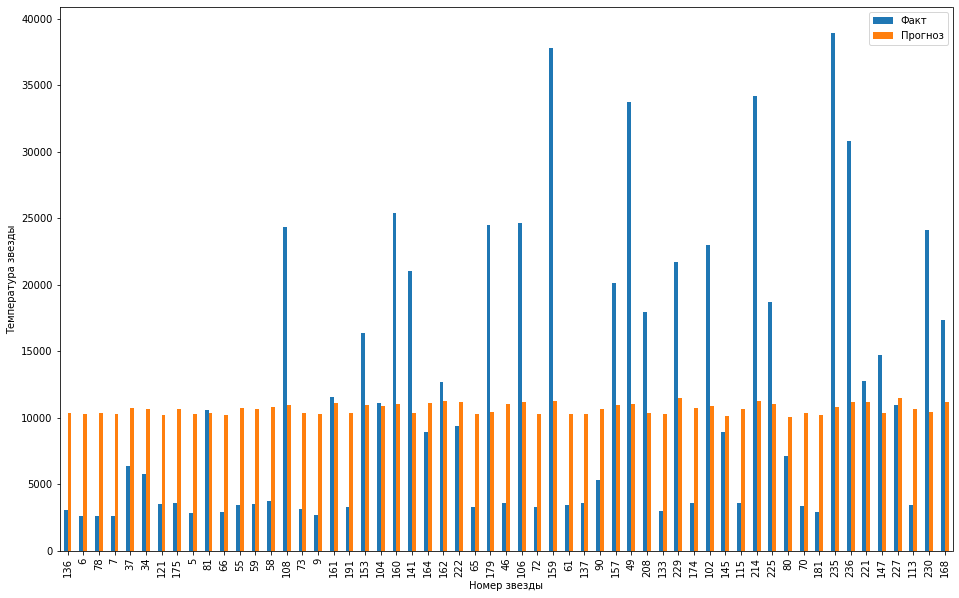

In [29]:
data.plot(kind='bar',figsize=(16,10))
plt.xlabel('Номер звезды')
plt.ylabel('Температура звезды')
plt.show()

Нейронка без дополнительных настроек плохо предсказывает температуру

In [30]:
mean_squared_error(data['Факт'],data['Прогноз'])

103921010.0

In [31]:
mean_squared_error(data['Факт'],data['Прогноз'])**0.5

10194.165390065044

## Улучшение нейронной сети

In [32]:
net = NeuralNetRegressor(
    Net,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [33]:
params = {
    'lr': [0.05, .3, .5],
    'max_epochs': [1000],
    'module__num_units': [50, 100, 150],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='neg_mean_squared_error')
gs.fit(X_train, y_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0461        1.4855  0.0394
      2        1.0228        1.4738  0.0032
      3        1.0386        1.4621  0.0031
      4        1.0374        1.4496  0.0029
      5        1.0117        1.4424  0.0029
      6        1.0275        1.4355  0.0028
      7        1.0141        1.4322  0.0032
      8        1.0290        1.4241  0.0031
      9        0.9897        1.4204  0.0028
     10        1.0080        1.4150  0.0197
     11        1.0006        1.4096  0.0100
     12        1.0060        1.4072  0.0119
     13        1.0046        1.4032  0.0048
     14        1.0028        1.3975  0.0033
     15        0.9934        1.3957  0.0085
     16        0.9872        1.3917  0.0034
     17        0.9923        1.3886  0.0084
     18        0.9882        1.3880  0.0048
     19        1.0010        1.3841  0.0091
     20        1.0082        1.3792  0.0035
     21        0.9940        1.3

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.Net'>,
),
             param_grid={'lr': [0.05, 0.3, 0.5], 'max_epochs': [1000],
                         'module__num_units': [50, 100, 150]},
             refit=False, scoring='neg_mean_squared_error')

In [34]:
print(gs.best_score_, gs.best_params_)

-0.2640746881564458 {'lr': 0.3, 'max_epochs': 1000, 'module__num_units': 100}


In [35]:
from torch.optim import Adam

In [42]:
net = NeuralNetRegressor(
    Net,
    optimizer = Adam,
    criterion = nn.MSELoss,

    max_epochs = 1000,
    lr= 0.03, # gs.best_params_['lr'],
    module__num_units=200,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [43]:
net.fit(X_train, y_train)
test_preds = net.predict(X_test)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.0845        1.0355  0.0153
      2        1.0559        0.9631  0.0064
      3        1.0217        0.8681  0.0070
      4        0.9655        0.7668  0.0053
      5        0.9079        0.6313  0.0181
      6        0.8086        0.4434  0.0230
      7        0.6915        0.2473  0.0293
      8        0.5959        0.1786  0.0530
      9        0.5003        0.1645  0.0207
     10        0.3936        0.1569  0.0613
     11        0.5251        0.1792  0.0278
     12        0.4821        0.2043  0.0305
     13        0.4792        0.2317  0.0464
     14        0.4297        0.2161  0.0343
     15        0.4367        0.1931  0.0317
     16        0.4481        0.2188  0.0408
     17        0.5180        0.1930  0.0628
     18        0.3677        0.1726  0.0296
     19        0.4090        0.2137  0.0498
     20        0.4607        0.2647  0.0445
     21        0.3752        0.2

In [44]:
pred = pd.DataFrame(scaler1.inverse_transform(test_preds))
pred.index = test_y.index
test = pd.DataFrame(scaler1.inverse_transform(y_test.detach().numpy()))
test.index = test_y.index
data = pd.merge(test,pred, left_index=True, right_index=True,how='left')
data.columns = ['Факт', 'Прогноз']

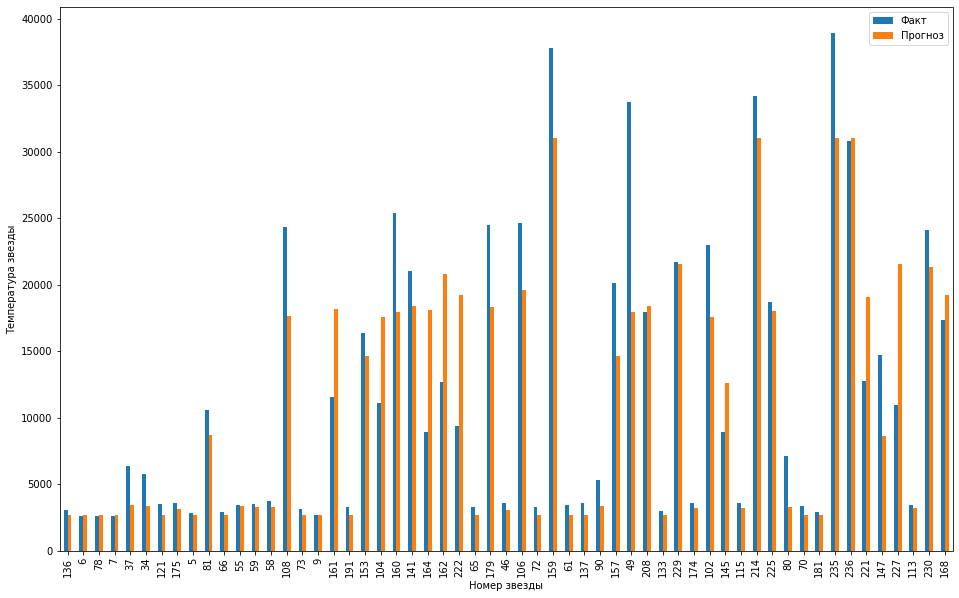

In [45]:
data.plot(kind='bar',figsize=(16,10))
plt.xlabel('Номер звезды')
plt.ylabel('Температура звезды')
plt.show()

In [46]:
mean_squared_error(data['Факт'],data['Прогноз'])

20879610.0

In [47]:
mean_squared_error(data['Факт'],data['Прогноз'])**0.5

4569.421188728393

Метрику удалось улучшить